In [1]:
%matplotlib inline
%pip install -q gdown
%pip install seaborn wordcloud scikit-learn


import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gdown

# Google Drive folder ID from the shared link
# https://drive.google.com/drive/folders/1TbQbDcHKhVurAJIOekhXysMrc1JpBpyg
folder_id = '1TbQbDcHKhVurAJIOekhXysMrc1JpBpyg'

# Download all_data.jsonl from the Google Drive folder
# First, let's download the entire folder or the specific file
output_dir = './dataset'
os.makedirs(output_dir, exist_ok=True)

# Download the folder contents
gdown.download_folder(id=folder_id, output=output_dir, quiet=False)

# Load the all_data.jsonl file
data_path = os.path.join(output_dir, 'all_data.jsonl')

if os.path.isfile(data_path):
    data = pd.read_json(data_path, lines=True)
    print(f'Loaded {len(data)} rows from {data_path}')
else:
    # If all_data.jsonl not found, try to load any .jsonl files in the folder
    dfs = []
    for fn in sorted(os.listdir(output_dir)):
        if fn.endswith('.jsonl'):
            path = os.path.join(output_dir, fn)
            try:
                df = pd.read_json(path, lines=True)
                dfs.append(df)
                print(f'Loaded {len(df)} rows from {fn}')
            except Exception as e:
                print('Failed to read', path, e)
    if not dfs:
        raise FileNotFoundError('No .jsonl files found in downloaded folder')
    data = pd.concat(dfs, ignore_index=True)

print('Dataframe shape:', data.shape)
display(data.head())

Retrieving folder contents


Processing file 1_yuuIgBVpE5Vfui3LpH_j_YQDYNdv5v5 all_data.jsonl
Processing file 1G3PA1UqNWoYnJiu5kDSEIOae49S-z1cF test.jsonl
Processing file 19zYKgEld03P3C_1SLH_5bTcx4Wix0a93 train.jsonl
Processing file 1SF0epR8kgAgdRdd_UYIiaGQAteEs9Hur val.jsonl


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1_yuuIgBVpE5Vfui3LpH_j_YQDYNdv5v5
From (redirected): https://drive.google.com/uc?id=1_yuuIgBVpE5Vfui3LpH_j_YQDYNdv5v5&confirm=t&uuid=551f1d2f-0f7b-48a4-a471-4b8203ff8600
To: c:\Users\movin\Downloads\deploy\sinXdetect\ml\data_analysis\dataset\all_data.jsonl
  0%|          | 0.00/241M [00:00<?, ?B/s]Downloading...
From (original): https://drive.google.com/uc?id=1_yuuIgBVpE5Vfui3LpH_j_YQDYNdv5v5
From (redirected): https://drive.google.com/uc?id=1_yuuIgBVpE5Vfui3LpH_j_YQDYNdv5v5&confirm=t&uuid=551f1d2f-0f7b-48a4-a471-4b8203ff8600
To: c:\Users\movin\Downloads\deploy\sinXdetect\ml\data_analysis\dataset\all_data.jsonl
100%|██████████| 241M/241M [00:35<00:00, 6.85MB/s] 

Downloading...
From: https://drive.google.com/uc?id=1G3PA1UqNWoYnJiu5kDSEIOae49S-z1cF
To: c:\Users\movin\Downloads\deploy\sinXdetect\ml\data_analysis\dataset\te

Loaded 99879 rows from ./dataset\all_data.jsonl
Dataframe shape: (99879, 4)


,text,label,meta,model
0,ප්‍රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්‍ය ...,AI,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN
1,ශ්‍රී ලංකා රජය දෙමළ සංවිධාන හයකට පනවා තිබූ තහන...,AI,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN
2,(අමදෝරු අමරජීව) රාජ්‍ය සේවා තරග විභාගයකදී වංචා...,HUMAN,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN
3,(ප්‍රින්ස් රත්නායක)ශ්‍රී ලංකා සබරගමුව විශ්වවිද...,HUMAN,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN
4,(ඩී.ජී.සුගතපාල)දඩල්ල මුහුදු වෙරලට පැමිණෙන පෙම්...,HUMAN,"{'source': 'www.lankadeepa.lk', 'url': 'https:...",NaN


In [3]:
# Basic info and checks
print(data.info())
print('Columns:', list(data.columns))
if 'text' not in data.columns or 'label' not in data.columns:
    raise ValueError('Expected columns `text` and `label` in the dataset')
data['label'] = data['label'].astype(str)
print('Label counts:')
print(data['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99879 entries, 0 to 99878
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    99879 non-null  object
 1   label   99879 non-null  object
 2   meta    99879 non-null  object
 3   model   5424 non-null   object
dtypes: object(4)
memory usage: 3.0+ MB
None
Columns: ['text', 'label', 'meta', 'model']
Label counts:
label
HUMAN    51810
AI       48069
Name: count, dtype: int64
None
Columns: ['text', 'label', 'meta', 'model']
Label counts:
label
HUMAN    51810
AI       48069
Name: count, dtype: int64


C:\Users\movin\AppData\Local\Temp\ipykernel_25464\3552219099.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=data, order=data['label'].value_counts().index, palette='muted')


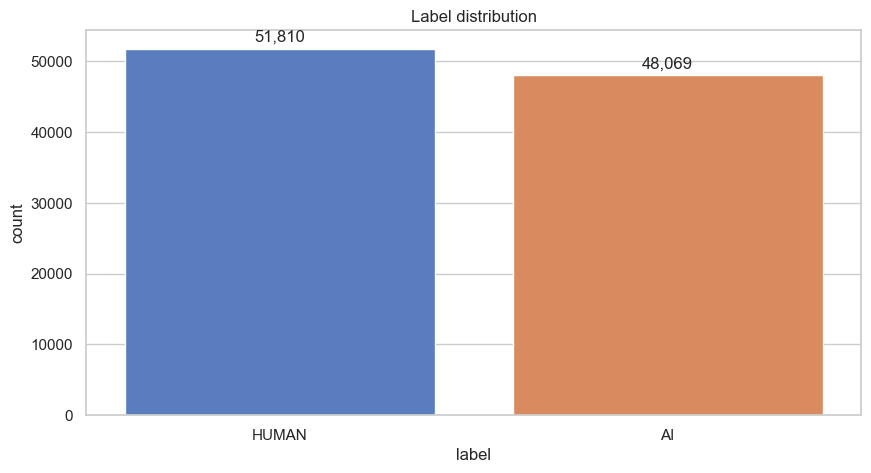

In [4]:
# Plot label distribution
ax = sns.countplot(x='label', data=data, order=data['label'].value_counts().index, palette='muted')
ax.set_title('Label distribution')
for p in ax.patches:
    ax.annotate(format(int(p.get_height()), ','), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0, 8), textcoords='offset points')
plt.show()

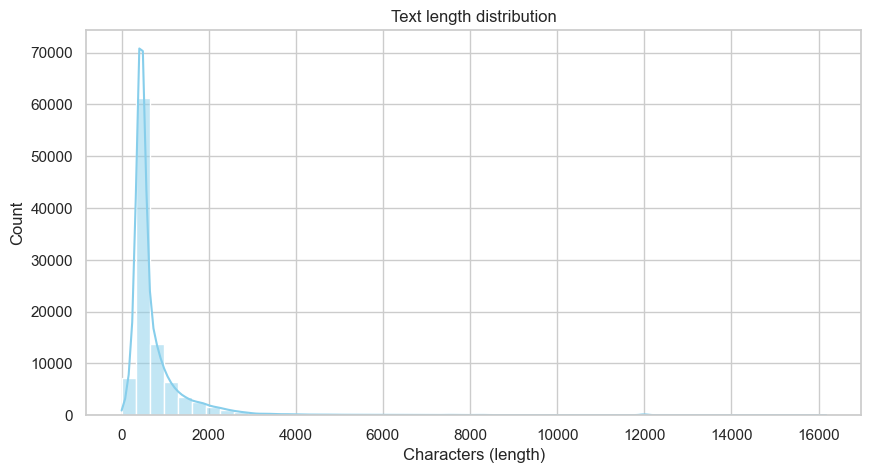

In [5]:
# Text length distribution
data['text_len'] = data['text'].astype(str).map(len)
sns.histplot(data=data, x='text_len', bins=50, kde=True, color='skyblue')
plt.title('Text length distribution')
plt.xlabel('Characters (length)')
plt.show()

In [6]:
# Simple preprocessing used for EDA (keeps Sinhala range, digits, ascii letters, basic punctuation)
import re
pattern = re.compile(r"[^\u0D80-\u0DFF0-9A-Za-z\.,;:!\?\(\)\"'\-\/\s]")
def preprocess_for_eda(text):
    if not isinstance(text, str):
        return ''
    text = text.replace('\u200d', '')
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = pattern.sub(' ', text)
    return re.sub(r'\s+', ' ', text).strip()

data['text_clean'] = data['text'].map(preprocess_for_eda)
data[['text', 'text_clean']].head()

,text,text_clean
0,ප්‍රකට කවියෙකු වන [කවියාගේ නම] ගේ නවතම කාව්‍ය ...,ප්රකට කවියෙකු වන කවියාගේ නම ගේ නවතම කාව්ය සංග්...
1,ශ්‍රී ලංකා රජය දෙමළ සංවිධාන හයකට පනවා තිබූ තහන...,ශ්රී ලංකා රජය දෙමළ සංවිධාන හයකට පනවා තිබූ තහනම...
2,(අමදෝරු අමරජීව) රාජ්‍ය සේවා තරග විභාගයකදී වංචා...,(අමදෝරු අමරජීව) රාජ්ය සේවා තරග විභාගයකදී වංචා ...
3,(ප්‍රින්ස් රත්නායක)ශ්‍රී ලංකා සබරගමුව විශ්වවිද...,(ප්රින්ස් රත්නායක)ශ්රී ලංකා සබරගමුව විශ්වවිද්ය...
4,(ඩී.ජී.සුගතපාල)දඩල්ල මුහුදු වෙරලට පැමිණෙන පෙම්...,(ඩී.ජී.සුගතපාල)දඩල්ල මුහුදු වෙරලට පැමිණෙන පෙම්...


Font downloaded to ./fonts\NotoSansSinhala-Regular.ttf
Font downloaded to ./fonts\NotoSansSinhala-Regular.ttf


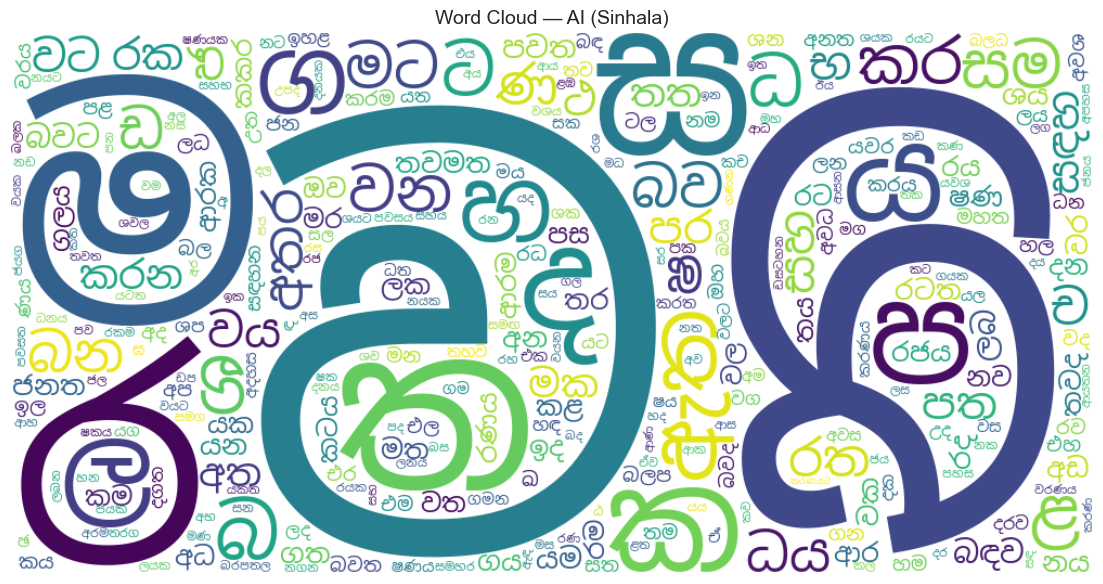

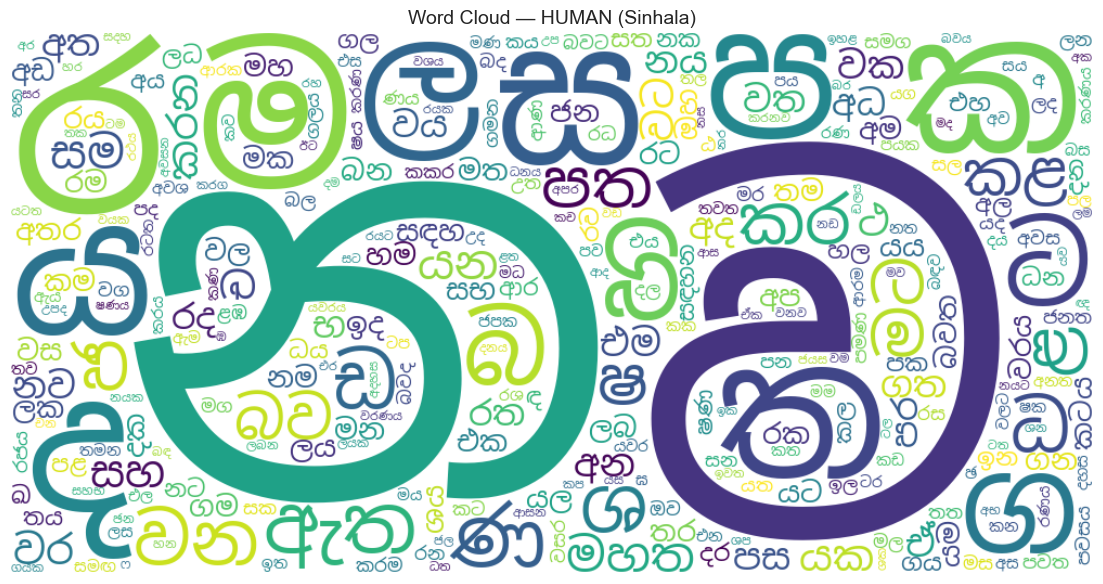

In [10]:
# Download Noto Sans Sinhala font for proper Sinhala text rendering in word clouds
import urllib.request

# Font setup
font_dir = './fonts'
os.makedirs(font_dir, exist_ok=True)
SINHALA_FONT_PATH = os.path.join(font_dir, 'NotoSansSinhala-Regular.ttf')

# Download the font if not already present (using GitHub raw URL)
if not os.path.exists(SINHALA_FONT_PATH):
    print('Downloading Noto Sans Sinhala font...')
    # Direct TTF download from Google Noto Fonts GitHub repository
    font_url = 'https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansSinhala/NotoSansSinhala-Regular.ttf'
    try:
        urllib.request.urlretrieve(font_url, SINHALA_FONT_PATH)
        print(f'Font downloaded to {SINHALA_FONT_PATH}')
    except Exception as e:
        print(f'Could not download font from primary URL: {e}')
        # Try alternative URL
        try:
            alt_font_url = 'https://cdn.jsdelivr.net/gh/nickshanks/Noto@main/NotoSansSinhala-Regular.ttf'
            urllib.request.urlretrieve(alt_font_url, SINHALA_FONT_PATH)
            print(f'Font downloaded from alternative URL to {SINHALA_FONT_PATH}')
        except Exception as e2:
            print(f'Could not download font: {e2}')
            print('Word clouds will use default font (Sinhala may not render correctly)')
            SINHALA_FONT_PATH = None
else:
    print(f'Using existing font: {SINHALA_FONT_PATH}')

def generate_wordcloud(texts, title, font_path=None):
    """Generate and display a word cloud with optional Sinhala font support."""
    combined_text = " ".join(texts.dropna().astype(str).values.tolist())
    
    if len(combined_text) < 10:
        print(f'{title}: Too little text for a word cloud, skipping')
        return
    
    wc_params = {
        'width': 1000,
        'height': 500,
        'background_color': 'white',
        'collocations': False,
        'max_words': 300
    }
    
    if font_path and os.path.exists(font_path):
        wc_params['font_path'] = font_path
    
    wc = WordCloud(**wc_params).generate(combined_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Generate word clouds per label
labels = data['label'].unique()
for label in labels:
    subset = data[data['label'] == label]
    generate_wordcloud(
        subset['text_clean'],
        f'Word Cloud — {label} (Sinhala)',
        font_path=SINHALA_FONT_PATH
    )

In [8]:
# Top N-word and char n-grams per label
def top_ngrams(corpus, ngram_range=(1,1), top_k=20):
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

for label in labels:
    subset = data[data['label']==label]['text_clean'].astype(str).values
    print('\nTop word unigrams for label=', label)
    for w, c in top_ngrams(subset, ngram_range=(1,1), top_k=15):
        print(w, int(c))
    print('\nTop char 3-grams for label=', label)
    for w, c in top_ngrams(subset, ngram_range=(3,3), top_k=15):
        print(w, int(c))


Top word unigrams for label= AI
ඇත 148301
කර 70255
සම 67489
වන 62368
මට 60620
බව 55942
බන 51569
අතර 48034
ධය 44341
රත 42422
සහ 38955
වය 35231
වට 32506
පත 31834
පර 31679

Top char 3-grams for label= AI
ඇත 148301
කර 70255
සම 67489
වන 62368
මට 60620
බව 55942
බන 51569
අතර 48034
ධය 44341
රත 42422
සහ 38955
වය 35231
වට 32506
පත 31834
පර 31679

Top char 3-grams for label= AI


KeyboardInterrupt: 

In [ ]:
# Save a small sample for manual inspection
sample_out = 'eda_sample.csv'
data.sample(min(1000, len(data))).to_csv(sample_out, index=False)
print(f'Saved sample to {sample_out}')

**Notes & next steps**
- For token-level statistics or better Sinhala tokenization, consider using `sentencepiece` or a language-specific tokenizer.
- For very large datasets, sample before generating wordclouds or n-grams to reduce memory use.
- I can extend this notebook to export a features CSV (TF-IDF) or run quick baseline models if you want.